In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import trompy as tp

In [2]:
DATAFOLDER = Path("..\\data")
FIGSFOLDER = Path("..\\figures")
FIGSFOLDER = Path("C:\\Users\\jmc010\\Dropbox\\Publications in Progress\\IPP Giulia paper\\figs")

def tweak_df(df):

    return (df
            .query("session == 's4'")
            )

df = pd.read_excel(DATAFOLDER / "metafile_ipp.xlsx", sheet_name="metafile Exp 1")
df = tweak_df(df)

In [3]:
def get_licks_per_solution(row):
    filename = row.medfile
    # print(f"Processing {filename}")

    L, R = tp.medfilereader(DATAFOLDER / filename, vars_to_extract=["b", "e"], remove_var_header=True)

    if "malt" in row.bottleL and "cas" in row.bottleR:
        med_var_malt, med_var_casein = L, R
    elif "malt" in row.bottleR and "cas" in row.bottleL:
        med_var_malt, med_var_casein = R, L
    else:
        raise ValueError("Bottles not found")
    
    return med_var_casein, med_var_malt

### Panel 2A

In [4]:
def get_cluster_number(licks, threshold=0.5):
    lickdata = tp.lickCalc(licks, burstThreshold=threshold)
    return lickdata["bNum"]

# get cluster number
PR_cas_cluster_num, PR_malt_cluster_num = [], []
for row in df.query("dietgroup == 'PR'").iterrows():
    cas_licks, malt_licks = get_licks_per_solution(row[1])
    
    PR_cas_cluster_num.append(get_cluster_number(cas_licks))
    PR_malt_cluster_num.append(get_cluster_number(malt_licks))

NR_cas_cluster_num, NR_malt_cluster_num = [], []
for row in df.query("dietgroup == 'NR'").iterrows():
    cas_licks, malt_licks = get_licks_per_solution(row[1])
    
    NR_cas_cluster_num.append(get_cluster_number(cas_licks))
    NR_malt_cluster_num.append(get_cluster_number(malt_licks))

c:\Users\jmc010\AppData\Local\miniconda3\Lib\site-packages\trompy\lickcalc.py:239: RuntimeWarning: invalid value encountered in power
  return (np.exp(-(alpha*x)**beta))
c:\Users\jmc010\AppData\Local\miniconda3\Lib\site-packages\trompy\lickcalc.py:239: RuntimeWarning: invalid value encountered in power
  return (np.exp(-(alpha*x)**beta))


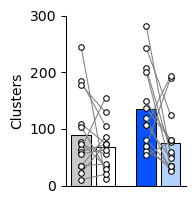

In [5]:
colors = ["xkcd:silver", "white", "xkcd:electric blue", "xkcd:powder blue"]

f, ax = plt.subplots(figsize=(2, 2),
                     gridspec_kw={"left": 0.35, "bottom": 0.1, "top": 0.95, "right": 0.95})

tp.barscatter([[NR_cas_cluster_num, NR_malt_cluster_num], [PR_cas_cluster_num, PR_malt_cluster_num],],
              ax=ax,
              paired=True,
              barfacecolor_option="individual",
              barfacecolor=colors,
              scattersize=40
            );

ax.set_yticks([0, 100, 200, 300])
ax.set_ylabel("Clusters")

f.savefig(FIGSFOLDER / "2A_cluster number.pdf", dpi=300)

### Panel 2B

In [6]:
def get_cluster_size(licks, threshold=0.5):
    lickdata = tp.lickCalc(licks, burstThreshold=threshold)
    return lickdata["bMean"]

# get cluster size
PR_cas_cluster_size, PR_malt_cluster_size = [], []
for row in df.query("dietgroup == 'PR'").iterrows():
    cas_licks, malt_licks = get_licks_per_solution(row[1])
    
    PR_cas_cluster_size.append(get_cluster_size(cas_licks))
    PR_malt_cluster_size.append(get_cluster_size(malt_licks))

NR_cas_cluster_size, NR_malt_cluster_size = [], []
for row in df.query("dietgroup == 'NR'").iterrows():
    cas_licks, malt_licks = get_licks_per_solution(row[1])
    
    NR_cas_cluster_size.append(get_cluster_size(cas_licks))
    NR_malt_cluster_size.append(get_cluster_size(malt_licks))

c:\Users\jmc010\AppData\Local\miniconda3\Lib\site-packages\trompy\lickcalc.py:239: RuntimeWarning: invalid value encountered in power
  return (np.exp(-(alpha*x)**beta))
c:\Users\jmc010\AppData\Local\miniconda3\Lib\site-packages\trompy\lickcalc.py:239: RuntimeWarning: invalid value encountered in power
  return (np.exp(-(alpha*x)**beta))


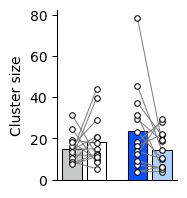

In [7]:
colors = ["xkcd:silver", "white", "xkcd:electric blue", "xkcd:powder blue"]

f, ax = plt.subplots(figsize=(2, 2),
                     gridspec_kw={"left": 0.35, "bottom": 0.1, "top": 0.95, "right": 0.95})

tp.barscatter([[NR_cas_cluster_size, NR_malt_cluster_size], [PR_cas_cluster_size, PR_malt_cluster_size],],
              ax=ax,
              paired=True,
              barfacecolor_option="individual",
              barfacecolor=colors,
              scattersize=40
            );

ax.set_yticks([0, 20, 40, 60, 80])
ax.set_ylabel("Cluster size")

f.savefig(FIGSFOLDER / "2B_cluster size.pdf", dpi=300)

### Panel 2C

In [18]:
# work out preference scores for later correlations
 
NR_pref, PR_pref = [], []
for row in df.query("dietgroup == 'NR'").iterrows():
    cas_licks, malt_licks = get_licks_per_solution(row[1])

    NR_pref.append(len(cas_licks) / (len(cas_licks) + len(malt_licks)))

for row in df.query("dietgroup == 'PR'").iterrows():
    cas_licks, malt_licks = get_licks_per_solution(row[1])

    PR_pref.append(len(cas_licks) / (len(cas_licks) + len(malt_licks)))


In [19]:
def keep_specific_epoch(licks, tmin=0, tmax=3600):
    return [lick for lick in licks if tmin <= lick <= tmax]

def divide_bursts_into_first_and_third_epoch(licks):
    
    lickdata = tp.lickCalc(licks, burstThreshold=0.5, minburstlength=3)
    bursts = lickdata["bLicks"]
    nbursts = len(bursts)
    epoch1 = np.mean(bursts[1:nbursts//3])
    epoch3 = np.mean(bursts[nbursts//3*2:-1])

    return epoch1, epoch3

dietgroup = "NR"
# get cluster number
cas_size_first, cas_size_last = [], []
malt_size_first, malt_size_last = [], []
for row in df.query("dietgroup == @dietgroup").iterrows():
    cas_licks, malt_licks = get_licks_per_solution(row[1])

    c1, c2 = divide_bursts_into_first_and_third_epoch(cas_licks)
    cas_size_first.append(c1)
    cas_size_last.append(c2)

    m1, m2 = divide_bursts_into_first_and_third_epoch(malt_licks)
    malt_size_first.append(m1)
    malt_size_last.append(m2)

delta_cas = np.array(cas_size_last) / np.array(cas_size_first) * 100
delta_malt = np.array(malt_size_last) / np.array(malt_size_first) * 100


c:\Users\jmc010\AppData\Local\miniconda3\Lib\site-packages\trompy\lickcalc.py:239: RuntimeWarning: invalid value encountered in power
  return (np.exp(-(alpha*x)**beta))


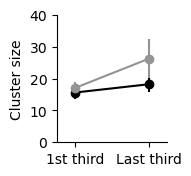

In [20]:
def sem(data):
    return np.std(data) / np.sqrt(len(data))

f, ax = plt.subplots(figsize=(2, 1.7),
                     gridspec_kw={"left": 0.35, "bottom": 0.2, "top": 0.95, "right": 0.90})

ax.errorbar([1, 2], [np.mean(cas_size_first), np.mean(cas_size_last)],
            yerr=[sem(cas_size_first), sem(cas_size_last)],
            fmt="o-", color="black", label="Cas")

ax.errorbar([1, 2], [np.mean(malt_size_first), np.mean(malt_size_last)],
            yerr=[sem(malt_size_first), sem(malt_size_last)],
            fmt="o-", color="xkcd:grey", label="Malt")

ax.set_ylim(0,40)
ax.set_xlim(0.75, 2.25)
ax.set_ylabel("Cluster size")
ax.set_xticks([1, 2], labels=["1st third", "Last third"])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

f.savefig(FIGSFOLDER / "2C_cluster size first and last epoch_NR.pdf", dpi=300)

### Panel 2E

Cas -0.09095149639443265 0.7571524267350138
Malt -0.48250925774663 0.08055853868765712


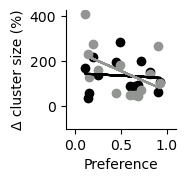

In [21]:
from scipy.stats import linregress

f, ax = plt.subplots(figsize=(2, 1.7),
                     gridspec_kw={"left": 0.35, "bottom": 0.25, "top": 0.95, "right": 0.90})

ax.scatter(NR_pref, delta_cas, color="black", label="Cas")
ax.scatter(NR_pref, delta_malt, color="xkcd:grey", label="Malt")

slope, intercept, r_value, p_value, std_err = linregress(NR_pref, delta_cas)
cas_regression = slope * np.array(NR_pref) + intercept
print("Cas", r_value, p_value)

ax.plot(NR_pref, cas_regression, color="black")

slope, intercept, r_value, p_value, std_err = linregress(NR_pref, delta_malt)
malt_regression = slope * np.array(NR_pref) + intercept
print("Malt", r_value, p_value)

ax.plot(NR_pref, malt_regression, color="xkcd:grey")

ax.set_ylim(-100, 430)
ax.set_xlim(-0.1, 1.1)
ax.set_xticks([0, 0.5, 1])

ax.set_ylabel("\u0394 cluster size (%)")
ax.set_xlabel("Preference")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

f.savefig(FIGSFOLDER / "2E_cluster size vs preference_NR.pdf", dpi=300)

In [13]:
dietgroup = "PR"
# get cluster number
cas_size_first, cas_size_last = [], []
malt_size_first, malt_size_last = [], []
for row in df.query("dietgroup == @dietgroup").iterrows():
    cas_licks, malt_licks = get_licks_per_solution(row[1])

    c1, c2 = divide_bursts_into_first_and_third_epoch(cas_licks)
    cas_size_first.append(c1)
    cas_size_last.append(c2)

    m1, m2 = divide_bursts_into_first_and_third_epoch(malt_licks)
    malt_size_first.append(m1)
    malt_size_last.append(m2)

delta_cas = np.array(cas_size_last) / np.array(cas_size_first) * 100
delta_malt = np.array(malt_size_last) / np.array(malt_size_first) * 100

c:\Users\jmc010\AppData\Local\miniconda3\Lib\site-packages\trompy\lickcalc.py:239: RuntimeWarning: invalid value encountered in power
  return (np.exp(-(alpha*x)**beta))


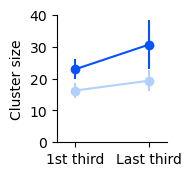

In [14]:
f, ax = plt.subplots(figsize=(2, 1.7),
                     gridspec_kw={"left": 0.35, "bottom": 0.2, "top": 0.95, "right": 0.90})

ax.errorbar([1, 2], [np.mean(cas_size_first), np.mean(cas_size_last)],
            yerr=[sem(cas_size_first), sem(cas_size_last)],
            fmt="o-", color="xkcd:electric blue", label="Cas")

ax.errorbar([1, 2], [np.mean(malt_size_first), np.mean(malt_size_last)],
            yerr=[sem(malt_size_first), sem(malt_size_last)],
            fmt="o-", color="xkcd:powder blue", label="Malt")

ax.set_ylim(0,40)
ax.set_xlim(0.75, 2.25)
ax.set_ylabel("Cluster size")
ax.set_xticks([1, 2], labels=["1st third", "Last third"])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

f.savefig(FIGSFOLDER / "2D_cluster size first and last epoch_PR.pdf", dpi=300)

Cas 0.5218762297261321 0.0556013586390133
Malt 0.28095914575003755 0.330537110780067


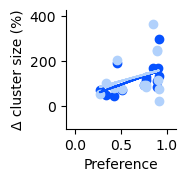

In [17]:
from scipy.stats import linregress

f, ax = plt.subplots(figsize=(2, 1.7),
                     gridspec_kw={"left": 0.35, "bottom": 0.25, "top": 0.95, "right": 0.90})

ax.scatter(PR_pref, delta_cas, color="xkcd:electric blue", label="Cas")
ax.scatter(PR_pref, delta_malt, color="xkcd:powder blue", label="Malt")

slope, intercept, r_value, p_value, std_err = linregress(PR_pref, delta_cas)
cas_regression = slope * np.array(PR_pref) + intercept
print("Cas", r_value, p_value)

ax.plot(PR_pref, cas_regression, color="xkcd:electric blue")

slope, intercept, r_value, p_value, std_err = linregress(PR_pref, delta_malt)
malt_regression = slope * np.array(PR_pref) + intercept
print("Malt", r_value, p_value)

ax.plot(PR_pref, malt_regression, color="xkcd:powder blue")

ax.set_ylim(-100, 430)
ax.set_xlim(-0.1, 1.1)
ax.set_xticks([0, 0.5, 1])

ax.set_ylabel("\u0394 cluster size (%)")
ax.set_xlabel("Preference")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

f.savefig(FIGSFOLDER / "2F_cluster size first and last epoch_PR.pdf", dpi=300)

In [52]:
PR_pref

[0.7562254259501966,
 0.7764758900405588,
 0.9136642869002158,
 0.8474214220323466,
 0.8931709265175719,
 0.775,
 0.3402262973078424,
 0.2699696663296259,
 0.8893648724157198,
 0.9046225863077824,
 0.912850812407681,
 0.42653476869362816,
 0.5084241823587711,
 0.4532471437161756]